## Plotting different assumptions for $k_{\rm NL}(z)$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import revelant packages
from FishLSS.headers import *
from FishLSS.twoPoint import *
from FishLSS.twoPointNoise import *
import FishLSS.parameter_forecast as pf

In [3]:
# Get default matplotlib color cycle, so that we can repeat colors easily in plots
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
from matplotlib.colors import LogNorm

In [5]:
out_dir = "../output/specderivs/pkplot_chordnoise/nonoise/"

fc_names = [
    "puma_32k_opt", 
]

In [7]:
fc = {}
for name in fc_names:
    print(f"** Loading {name}")
    fc[name] = pf.load_forecast(name, verbose=False, out_root_dir=out_dir)

** Loading puma_32k_opt


## Computing wedge "slope" as function of redshift

In [8]:
def theta_w(z, N_w):
    lam_obs = 0.21 * (1 + z)
    D_phys = 6
    return N_w * (1.22 / 2 / 0.7**0.5) * lam_obs / D_phys

def wedge_slope(z, N_w, cosmo, horizon=False):
    # This is the m parameter in kpar < kperp * m
    h = fc_for_ps['forecast'].cosmo.Hubble(0) * 3e5 / 100 # Little h
    
    if not np.isscalar(z):
        chi = np.array([(1 + z_) * cosmo.angular_distance(z_) * h for z_ in z]) # Mpc/h
        H = np.array([fc_for_ps['forecast'].cosmo.Hubble(z_) / h for z_ in z]) # h/Mpc
    else:
        chi = (1 + z) * cosmo.angular_distance(z) * h # Mpc/h
        H = fc_for_ps['forecast'].cosmo.Hubble(z) / h # h/Mpc
    
    sin_factor = 1 if horizon else np.sin(theta_w(z, N_w))
    
    return chi * H / (1 + z) * sin_factor

## Plots

### $k_{\rm NL}(z)$, for appendix

In [9]:
fc_for_ps = fc["puma_32k_opt"]

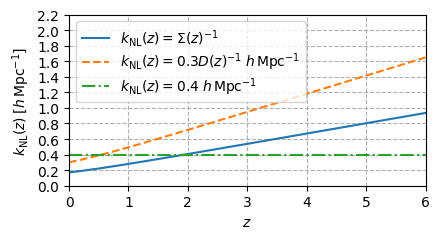

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.5), sharex=True)

z_plot = np.linspace(0, 6, 1000)
ax.plot(
    z_plot, 
    [1/fc['puma_32k_opt']['forecast'].Sigma2(z)**0.5 for z in z_plot], 
    label=r"$k_{\rm NL}(z) = \Sigma(z)^{-1}$",
    c=colors[0],
    ls='-'
)
ax.plot(
    z_plot, 
    [0.3/fc_for_ps['forecast'].cosmo.scale_independent_growth_factor(z) for z in z_plot], 
    label=r"$k_{\rm NL}(z) = 0.3D(z)^{-1}\;h\,{\rm Mpc}^{-1}$",
    c=colors[1],
    ls='--'
)
ax.plot(
    z_plot, 
    0.4 * np.ones_like(z_plot), 
    label=r"$k_{\rm NL}(z) = 0.4\;h\,{\rm Mpc}^{-1}$",
    c=colors[2],
    ls='-.',
)

ax.set_ylim(0, 2.2)
ax.set_yticks(np.arange(0, 2.21, 0.2))
ax.set_xlim(0, 6)

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$k_{\rm NL}(z)\;[h\,{\rm Mpc}^{-1}]$")


for i in range(2):
    ax.grid(ls='--')
    ax.legend(labelspacing=0.2)
    

plt.tight_layout()
# plt.savefig("../plots/paper/knl_z.pdf")

### Wedge and $k_{\rm NL}$ in different $z$ bins

In [11]:
zi_for_plot = [0, 1, 3, 5, 7, 9]
z_wedge = [0.5, 1, 2, 3, 4, 5]
kperp_plot = np.linspace(0, 2, 20000)

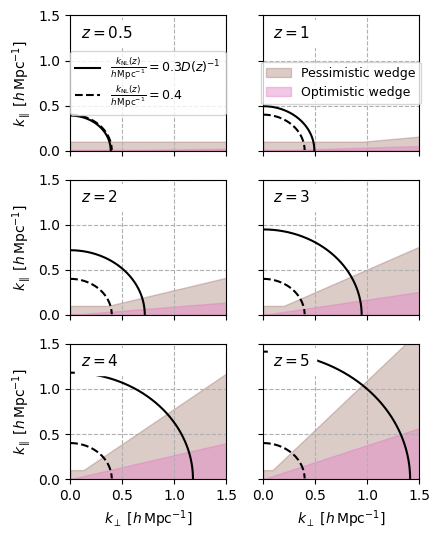

In [12]:
nx = 2
ny = 3

fig, ax = plt.subplots(ny, nx, figsize=(4.5, 5.5), sharex=True, sharey=True)

for axi, (zi, z) in enumerate(zip(zi_for_plot, z_wedge)):
    ax_ = ax.flatten()[axi]
    
    # print(z)
    beta_opt = wedge_slope(z, 1, fc_for_ps['forecast'].cosmo, horizon=False)
    beta_pess = wedge_slope(z, 3, fc_for_ps['forecast'].cosmo, horizon=False)
    kpar_boundary_opt = np.maximum(kperp_plot * beta_opt, 0.01)
    kpar_boundary_pess = np.maximum(kperp_plot * beta_pess, 0.1)
    # print(kpar_boundary_opt)
    
    knl_plot_p4 = np.sqrt(0.4**2 - kperp_plot[kperp_plot <= 0.4]**2)
    knl_p3dD = 0.3/fc_for_ps['forecast'].cosmo.scale_independent_growth_factor(z)
    knl_plot_p3dD = np.sqrt(knl_p3dD**2 - kperp_plot[kperp_plot <= knl_p3dD]**2)
    
    pess_label = "Pessimistic wedge" if axi == 1 else None
    opt_label = "Optimistic wedge" if axi == 1 else None
    
    ax_.fill_between(kperp_plot, kpar_boundary_pess, alpha=0.3, color=colors[5], label=pess_label)
    ax_.fill_between(kperp_plot, kpar_boundary_opt, alpha=0.4, color=colors[6], label=opt_label)
    
    # knlp3dD_label = r"$k_{\rm NL}(z) = 0.3D(z)^{-1}\;h\,{\rm Mpc}^{-1}$" if axi == 0 else None
    # knlp4_label = r"$k_{\rm NL}(z) = 0.4\;h\,{\rm Mpc}^{-1}$" if axi == 0 else None
    
    knlp3dD_label = r"$\frac{k_{\rm NL}(z)}{h\,{\rm Mpc}^{-1}} = 0.3D(z)^{-1}$" if axi == 0 else None
    knlp4_label = r"$\frac{k_{\rm NL}(z)}{h\,{\rm Mpc}^{-1}} = 0.4$" if axi == 0 else None
    
    ax_.plot(
        kperp_plot[kperp_plot <= knl_p3dD], 
        knl_plot_p3dD,
        c='k', 
        ls='-', 
        label=knlp3dD_label
    )
    ax_.plot(
        kperp_plot[kperp_plot <= 0.4], 
        knl_plot_p4, 
        c='k', 
        ls='--', 
        label=knlp4_label
    )
    
    ax_.grid(ls='--')
    ax_.set_xlim(0, 1.5)
    ax_.set_ylim(0, 1.5)
    # ax_.set_xticks(np.arange(0, 1.01, 0.5))
    # ax_.set_yticks(np.arange(0, 1.01, 0.25))
    
    ax_.text(0.1, 1.25, rf"$z = {z}$", fontsize=11, backgroundcolor='white')
    
ax[0,0].legend(fontsize=9, loc='center', labelspacing=0.1)
ax[0,1].legend(fontsize=9, loc='center')

for i in range(nx):
    ax[ny-1, i].set_xlabel(r"$k_\perp\;[h\,{\rm Mpc}^{-1}]$")
    
for i in range(ny):
    ax[i, 0].set_ylabel(r"$k_\parallel\;[h\,{\rm Mpc}^{-1}]$")

plt.tight_layout()
# plt.savefig("../plots/paper/wedge.pdf")